In [3]:
import numpy as np
%matplotlib qt
import matplotlib.pyplot as pl
import time
import pickle
import os
import math

In [4]:
from transfer_matrix import load_bit_state, free_energy_uniform, State

In [5]:
def get_ancilla_array(L,T,pattern='random',preference='E',seed=1,p_O=0.5): #preference decides to give preference to E or O for initial time step in case they cannot be equally distributed
    """
    -1 corresponds to ancilla given to Environment
    +1 corresponds to ancilla given to Observer
    0 corresponds to there being no ancilla; that is the transfer matrix is that of Haar dynamics
    E.g, a_structure[t,x] = -1 means that the ancilla at (x,t) belongs to Environemnt
    """
    if pattern == 'checkerboard':
        a_structure = (np.indices((T,L)).sum(axis=0) % 2)
        if preference == 'E':
            a_structure = 2*a_structure - 1
        elif preference == 'O':
            a_structure = 1-2*a_structure

    if pattern == 'alternate':
        a_structure = np.ones((T,L))
        for t in range(T):
            if preference == 'E':
                if t%2==0:
                    a_structure[t,:] = -1
            elif preference == 'O':
                if t%2==1:
                    a_structure[t,:] = -1

    if pattern == 'random':
        rng = np.random.default_rng(seed=seed)
        a_structure = np.round(rng.binomial(1,p_O,(T,L)))
        a_structure = 2*a_structure - 1

    if pattern == 'boundary':
        a_structure = np.zeros((T,L))
        a_structure[:,0] = -1
        
    return a_structure

In [6]:
## Calculate coherent QI for a single encoded bell pair.
def delta_F(L,p,q,pattern='random',seed=1,preference='E',intermediate_time=False,p_O=0.5):

    T = 2*L
    q = 2
  
    F_t = []
    # Load initial_states
    state_up = load_bit_state(L,2*L,q,'up')
    state_down = load_bit_state(L,2*L,q,'down')
    state_up.p = p
    state_down.p = p

    # get ancilla structure. This is an array which decides whether the particular ancilla goes to O or E
    a_structure = get_ancilla_array(L,T,pattern=pattern,seed=seed,preference=preference,p_O=p_O)

    # Calculate free energy
    state_up,top_layer_up= free_energy_uniform(state_up,T,a_structure,intermediate_time=intermediate_time)
    state_down, top_layer_down= free_energy_uniform(state_down,T,a_structure,intermediate_time=intermediate_time)

    # Free energy difference as a function of time
    if intermediate_time:
        for t in range(T):
            temp_up = np.sum(state_up.log_Z[:1+t+1]) + top_layer_up[t]
            temp_down = np.sum(state_down.log_Z[:1+t+1]) + top_layer_down[t]
            F_t.append(temp_down-temp_up)
    else:
        temp_up = np.sum(state_up.log_Z[:1+T]) + top_layer_up[-1]
        temp_down = np.sum(state_down.log_Z[:1+T]) + top_layer_down[-1]
        F_t.append(temp_down-temp_up)
    return F_t       

## Alternate Scheme

In [12]:
L_list = [8,10,12,14,16,18]
p_list = np.round(np.linspace(0.3,1,20),2)
intermediate_time = False
if intermediate_time:
    F_t = {}
F = {}
q=2
for L in L_list:
    F[L] = []
    # F_t[L] = {}
    for p in p_list:
        diff_F = delta_F(L,p,q,pattern='alternate',preference='E',intermediate_time=False)
        if intermediate_time: F_t[L][p] = diff_F
        F[L].append(diff_F[-1])


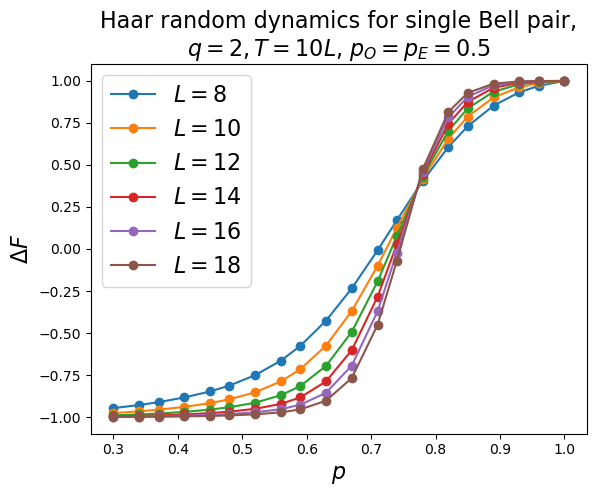

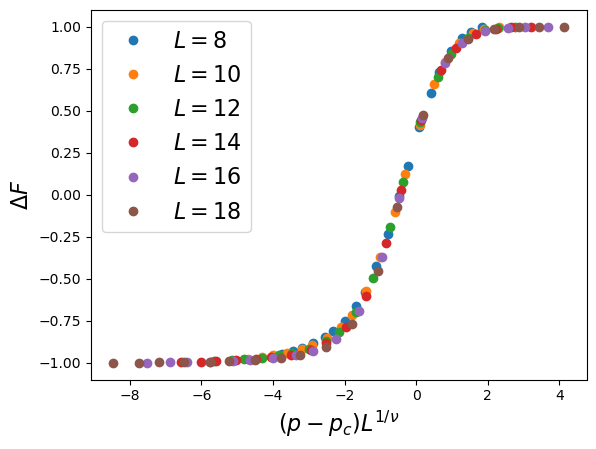

In [42]:
%matplotlib inline
p_c = 0.77
nu = 1
fig,ax = pl.subplots(1,1)
fig2,ax2 = pl.subplots(1,1)
# ax2 = pl.subplot(1,1,1,figure=2)
for L in F:
    ax.plot(p_list,np.array(F[L])/np.log(q),'-o',label = r'$L=$'+str(L))
    ax2.plot((np.array(p_list)-p_c)*L**(1/nu),np.array(F[L])/np.log(q),'o',label = r'$L=$'+str(L))

ax.set_ylabel(r'$\Delta F$',fontsize=16)
ax2.set_ylabel(r'$\Delta F$',fontsize=16)
ax.set_xlabel(r'$p$',fontsize=16)
ax2.set_xlabel(r'$(p-p_c)L^{1/\nu}$',fontsize=16)

ax.set_title(r'Haar random dynamics for single Bell pair,'+'\n'+ '$q=2,T=10L$, $p_O=p_E=0.5$',fontsize=16)

ax.legend(fontsize=16)
ax2.legend(fontsize=16)


## Checkerboard

In [43]:
L_list = [8,10,12,14,16,18]
p_list = np.round(np.linspace(0.3,1,20),2)
intermediate_time = False
if intermediate_time:
    F_t = {}
F = {}
q=2
for L in L_list:
    F[L] = []
    # F_t[L] = {}
    for p in p_list:
        diff_F = delta_F(L,p,q,pattern='checkerboard',preference='E',intermediate_time=False)
        if intermediate_time: F_t[L][p] = diff_F
        F[L].append(diff_F[-1])


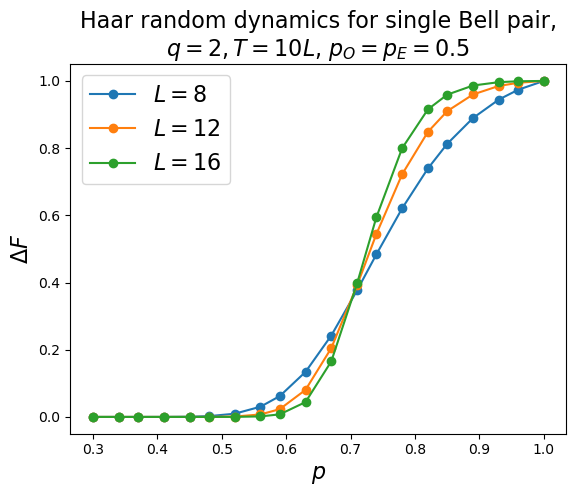

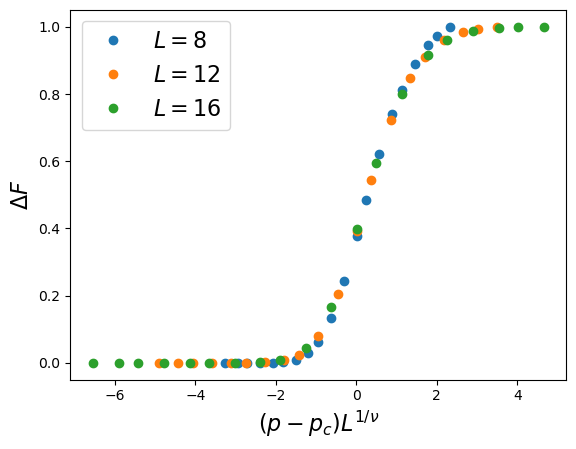

: 

In [47]:
%matplotlib inline
p_c = 0.7090
nu = 1
fig,ax = pl.subplots(1,1)
fig2,ax2 = pl.subplots(1,1)
# ax2 = pl.subplot(1,1,1,figure=2)
for L in F:
    if L%4==2:
        continue
    ax.plot(p_list,np.array(F[L])/np.log(q),'-o',label = r'$L=$'+str(L))
    ax2.plot((np.array(p_list)-p_c)*L**(1/nu),np.array(F[L])/np.log(q),'o',label = r'$L=$'+str(L))

ax.set_ylabel(r'$\Delta F$',fontsize=16)
ax2.set_ylabel(r'$\Delta F$',fontsize=16)
ax.set_xlabel(r'$p$',fontsize=16)
ax2.set_xlabel(r'$(p-p_c)L^{1/\nu}$',fontsize=16)

ax.set_title(r'Haar random dynamics for single Bell pair,'+'\n'+ '$q=2,T=10L$, $p_O=p_E=0.5$',fontsize=16)

ax.legend(fontsize=16)
ax2.legend(fontsize=16)


# Random

In [25]:
L_list = [8,10,12,14,16,18]
p_list = np.round(np.linspace(0.3,1,20),2)
intermediate_time = False
if intermediate_time:
    F_t = {}
F = {}
q=2
for L in L_list:
    F[L] = {}
    # F_t[L] = {}
    for p in p_list:
        F[L][p] = []
        for seed in np.arange(1,100,1):
            diff_F = delta_F(L,p,q,pattern='random',preference='E',intermediate_time=False,p_O=0.5,seed=seed)
            if intermediate_time: F_t[L][p] = diff_F
            F[L][p].append(diff_F[-1])


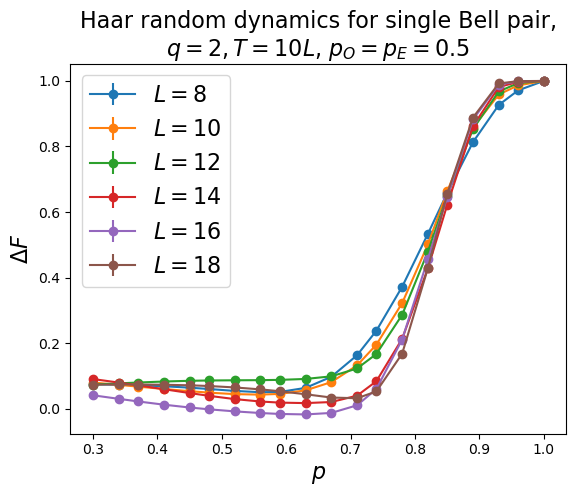

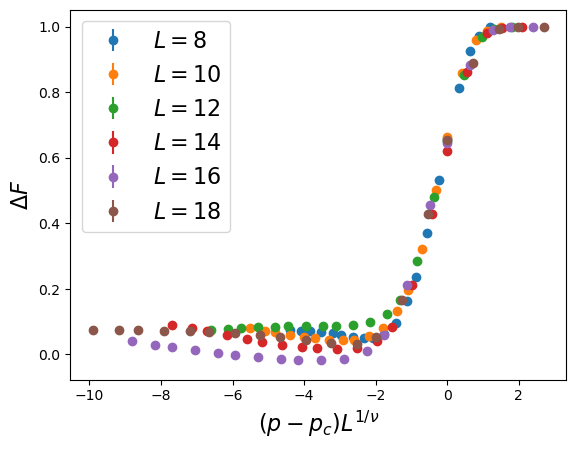

: 

In [27]:
%matplotlib inline
p_c = 0.85
nu = 1
fig,ax = pl.subplots(1,1)
fig2,ax2 = pl.subplots(1,1)
# ax2 = pl.subplot(1,1,1,figure=2)
for L in F:
    # if L%4==2:
    #     continue
    F_avg = []
    F_err = []
    for p in F[L]:
        F_avg.append(np.average(F[L][p]))
        F_err.append(np.std(F[L][p])/len(F[L][p]))
    ax.errorbar(p_list,np.array(F_avg)/np.log(q),yerr=F_err/np.log(q),ls='-',marker='o',label = r'$L=$'+str(L))
    ax2.errorbar((np.array(p_list)-p_c)*L**(1/nu),np.array(F_avg)/np.log(q),yerr=F_err/np.log(q),ls='',marker='o',label = r'$L=$'+str(L))

ax.set_ylabel(r'$\Delta F$',fontsize=16)
ax2.set_ylabel(r'$\Delta F$',fontsize=16)
ax.set_xlabel(r'$p$',fontsize=16)
ax2.set_xlabel(r'$(p-p_c)L^{1/\nu}$',fontsize=16)

ax.set_title(r'Haar random dynamics for single Bell pair,'+'\n'+ '$q=2,T=10L$, $p_O=p_E=0.5$',fontsize=16)

ax.legend(fontsize=16)
ax2.legend(fontsize=16)


# Boundary Disspiation

In [10]:
L_list = [8,10,12,14,16,18]
p_list = np.round(np.linspace(0.7,1,20),2)
intermediate_time = False
if intermediate_time:
    F_t = {}
F = {}
q=2
for L in L_list:
    F[L] = []
    # F_t[L] = {}
    for p in p_list:
        diff_F = delta_F(L,p,q,pattern='boundary',preference='E',intermediate_time=False)
        if intermediate_time: F_t[L][p] = diff_F
        F[L].append(diff_F[-1])


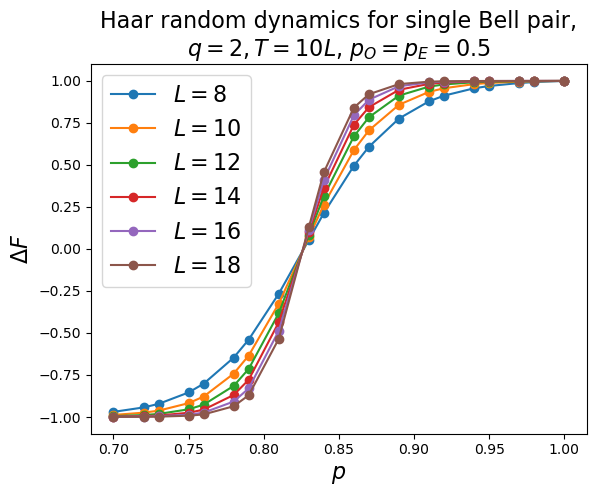

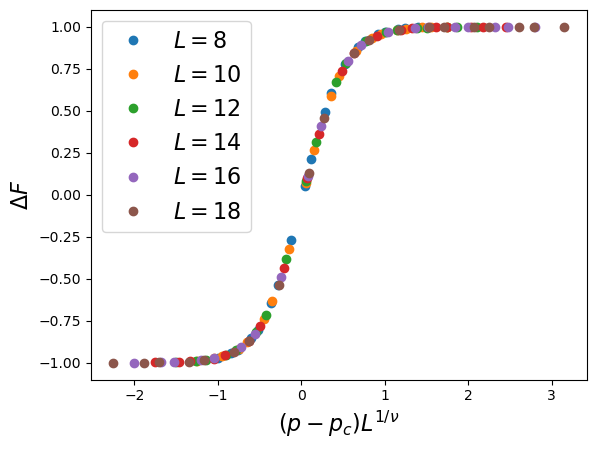

In [14]:
%matplotlib inline
p_c = 0.825
nu = 1
fig,ax = pl.subplots(1,1)
fig2,ax2 = pl.subplots(1,1)
# ax2 = pl.subplot(1,1,1,figure=2)
for L in F:
    ax.plot(p_list,np.array(F[L])/np.log(q),'-o',label = r'$L=$'+str(L))
    ax2.plot((np.array(p_list)-p_c)*L**(1/nu),np.array(F[L])/np.log(q),'o',label = r'$L=$'+str(L))

ax.set_ylabel(r'$\Delta F$',fontsize=16)
ax2.set_ylabel(r'$\Delta F$',fontsize=16)
ax.set_xlabel(r'$p$',fontsize=16)
ax2.set_xlabel(r'$(p-p_c)L^{1/\nu}$',fontsize=16)

ax.set_title(r'Haar random dynamics for single Bell pair,'+'\n'+ '$q=2,T=10L$, $p_O=p_E=0.5$',fontsize=16)

ax.legend(fontsize=16)
ax2.legend(fontsize=16)


In [15]:
for L in [16]:
    for p in F_t[L]:
        T_data = np.arange(1,len(F_t[L][p])+1,1)[::2]/L
        pl.plot(T_data,np.array(F_t[L][p])[::2]/(np.log(q)),'-o',label = r'$p=$'+str(p))
pl.legend()

In [14]:
p_c = 0
nu = np.inf
for L in F:
    pl.plot((np.array(p_list)-p_c)*L**(1/nu),[np.array(F_t[L][p][-1])/np.log(q) for p in p_list],'-o',label = r'$L=$'+str(L))

pl.ylabel(r'$\Delta F$',fontsize=16)
pl.xlabel(r'$p$',fontsize=16)

pl.title(r'Haar random dynamics for single Bell pair,'+'\n'+ '$q=2,T=10L$, $p_O=p_E=0.5$',fontsize=16)

pl.legend(fontsize=16)
pl.tight_layout()